#### 1. Train.csv 파일을 기준으로, 해당 URL의 악성 판단의 근거가 되는 시각화 예시

In [51]:
import pandas as pd
import numpy as np
from collections import Counter
import re

In [52]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [53]:
# 한글폰트 path 설정
font_path = 'C:\\windows\\Fonts\\malgun.ttf'

font_prop = fm.FontProperties(fname=font_path).get_name()
print(font_prop)

matplotlib.rc('font', family=font_prop)

Malgun Gothic


In [54]:
df = pd.read_csv('data/TrainData.csv')

print(type(df))
df.drop(columns=['Unnamed: 0'], inplace=True)

<class 'pandas.core.frame.DataFrame'>


In [55]:
print(df.columns)

Index(['url_len', 'url_num_hyphens_dom', 'url_num_dom_token', 'url_path_len',
       'url_filename_len', 'url_longest_dom_token_len',
       'url_average_dom_token_len', 'url_tld', 'url_domain_len',
       'url_hostname_len', 'url_num_dots', 'url_num_underscores',
       'url_num_equals', 'url_num_slashes', 'url_num_dash',
       'url_num_semicolon', 'url_num_at', 'url_num_percent', 'url_num_plus',
       'url_query_len', 'url_num_query_para', 'url_ip_present', 'url_entropy',
       'url_count_consonants', 'url_num_digits', 'url_chinese_present',
       'url_port', 'html_num_tags('iframe')', 'html_num_tags('script')',
       'html_num_tags('embed')', 'html_num_tags('object')',
       'html_num_tags('div')', 'html_num_tags('head')',
       'html_num_tags('body')', 'html_num_tags('form')', 'html_num_tags('a')',
       'html_num_tags('small')', 'html_num_tags('span')',
       'html_num_tags('input')', 'html_num_tags('applet')',
       'html_num_tags('img')', 'html_num_tags('video')',
    

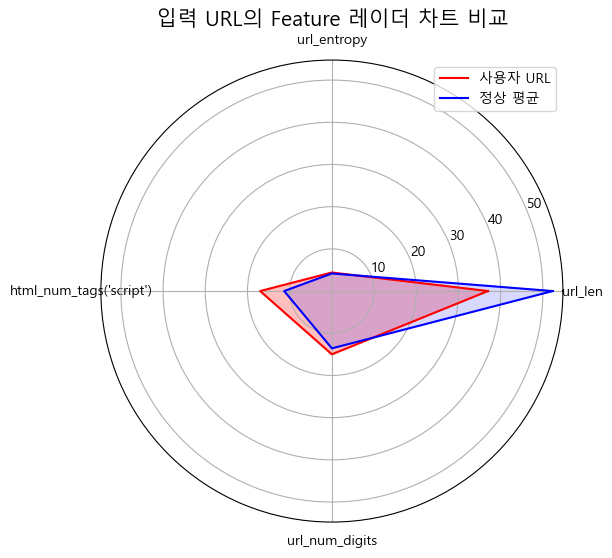

In [56]:
# 사용자가 입력한 URL의 특징들을 전반적으로 보여주고, 정상 평균과 비교
# 레이더 차트

user_data = df.iloc[[100]]  # 예시로 100번째 데이터를 사용자 입력이라고 가정

# 비교할 feature 선택
features = ['url_len', 'url_entropy', "html_num_tags('script')", 'url_num_digits']
user_values = user_data[features].values.flatten()
mean_benign = df[df['Result_v1']=='benign'][features].mean().values

# Radar Chart 구성
labels = features
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

user_values = np.concatenate((user_values, [user_values[0]]))
mean_benign = np.concatenate((mean_benign, [mean_benign[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, user_values, label='사용자 URL', color='red')
ax.plot(angles, mean_benign, label='정상 평균', color='blue')
ax.fill(angles, user_values, color='red', alpha=0.25)
ax.fill(angles, mean_benign, color='blue', alpha=0.15)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title('입력 URL의 Feature 레이더 차트 비교', size=15)
ax.legend(loc='upper right')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_22132\393484273.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Result_v1', y=feature, palette='Set3')


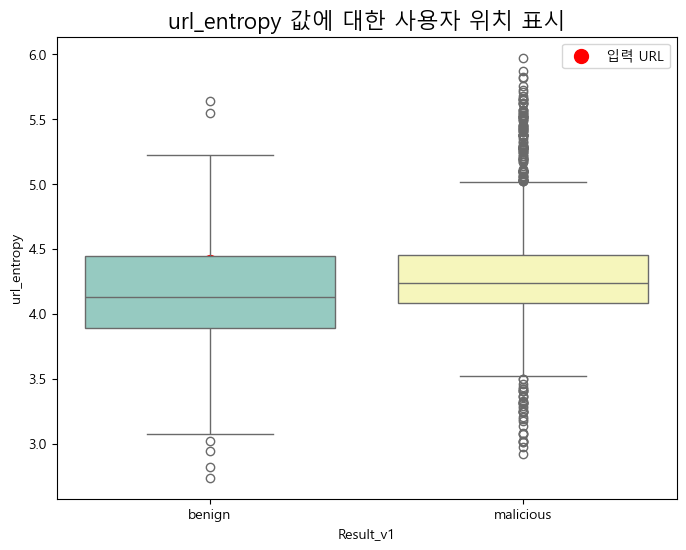

In [57]:
# 정상/악성 데이터 분포에 사용자 URL의 위치를 표시, 사용자의 Feature가 분포 상 어디에 가까운지 시각화함
feature = 'url_entropy'
user_value = user_data[feature].values[0]

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Result_v1', y=feature, palette='Set3')
plt.scatter(x=[0,1], y=[user_value, user_value], color='red', s=100, label='입력 URL')
plt.title(f'{feature} 값에 대한 사용자 위치 표시', fontsize=16)
plt.legend()
plt.show()

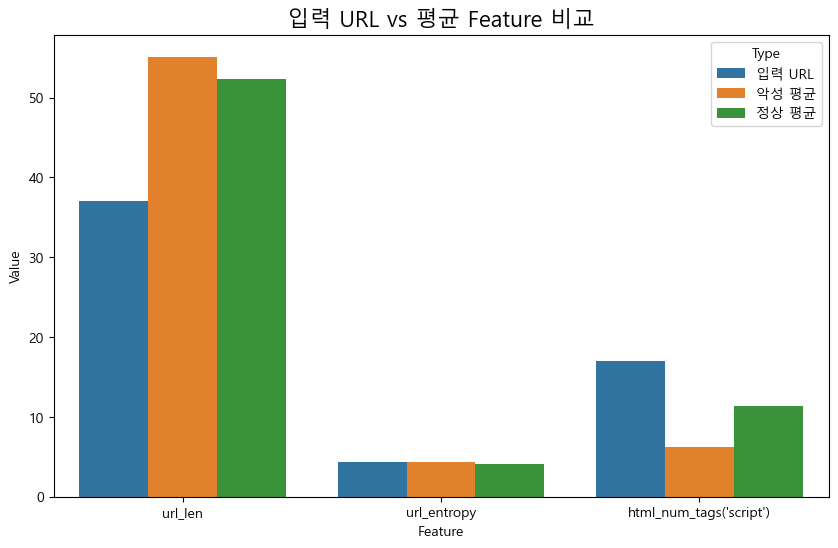

In [58]:
# 사용자 URL과 악성/정상 평균 Feature 비교
features = ['url_len', 'url_entropy', "html_num_tags('script')"]

user_vals = user_data[features].values.flatten()
malicious_mean = df[df['Result_v1'] == 'malicious'][features].mean()
benign_mean = df[df['Result_v1'] == 'benign'][features].mean()

plot_df = pd.DataFrame({
    'Feature': features,
    '입력 URL': user_vals,
    '악성 평균': malicious_mean.values,
    '정상 평균': benign_mean.values
})

plot_df = pd.melt(plot_df, id_vars='Feature', var_name='Type', value_name='Value')

plt.figure(figsize=(10,6))
sns.barplot(data=plot_df, x='Feature', y='Value', hue='Type')
plt.title('입력 URL vs 평균 Feature 비교', fontsize=16)
plt.show()

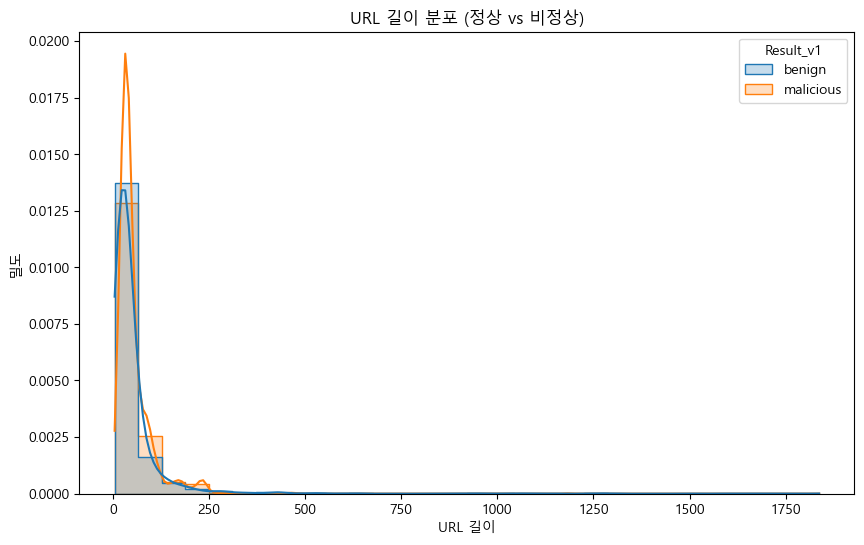

In [59]:
# 정상/비정상 URL의 길이 분포를 비교
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='url_len', hue='Result_v1', bins=30, kde=True, element='step', stat='density', common_norm=False)
plt.title("URL 길이 분포 (정상 vs 비정상)")
plt.xlabel("URL 길이")
plt.ylabel("밀도")
plt.show()

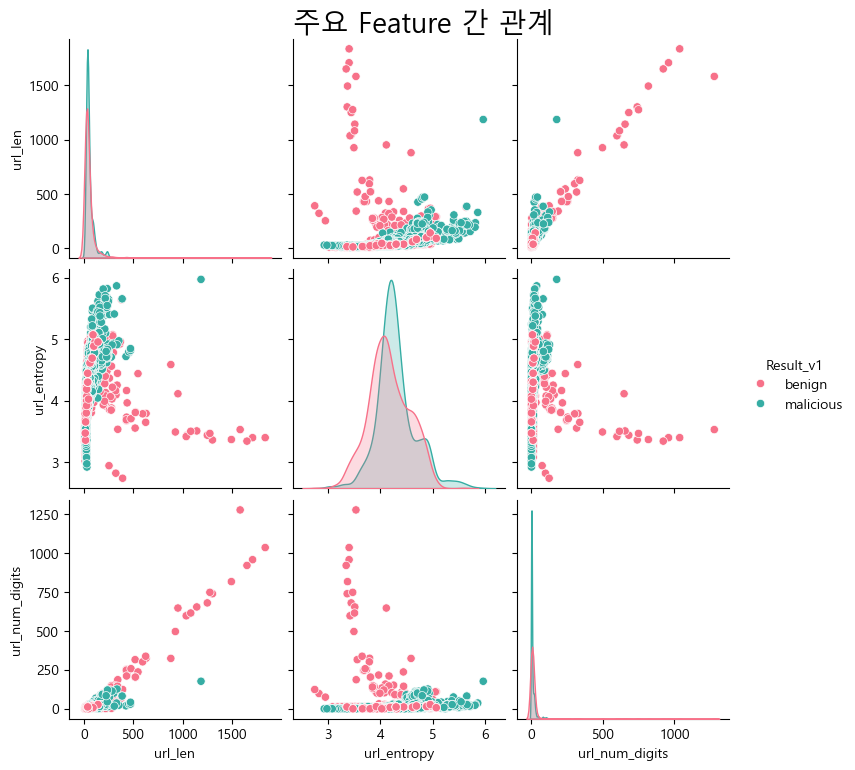

In [60]:
# 주요 Feature 간 관계
sns.pairplot(df[['url_len', 'url_entropy', 'url_num_digits', 'Result_v1']], 
             hue='Result_v1', palette='husl')
plt.suptitle('주요 Feature 간 관계', fontsize=20, y=1.02)
plt.show()

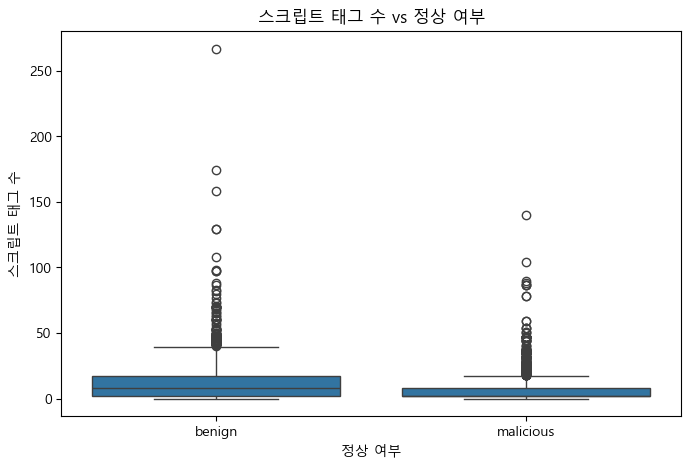

In [61]:
# html_num_tags('script') 태그 수의 분포를 통해 악성 페이지의 특징 파악
plt.figure(figsize=(8,5))
sns.boxplot(x='Result_v1', y="html_num_tags('script')", data=df)
plt.title("스크립트 태그 수 vs 정상 여부")
plt.xlabel("정상 여부")
plt.ylabel("스크립트 태그 수")
plt.show()

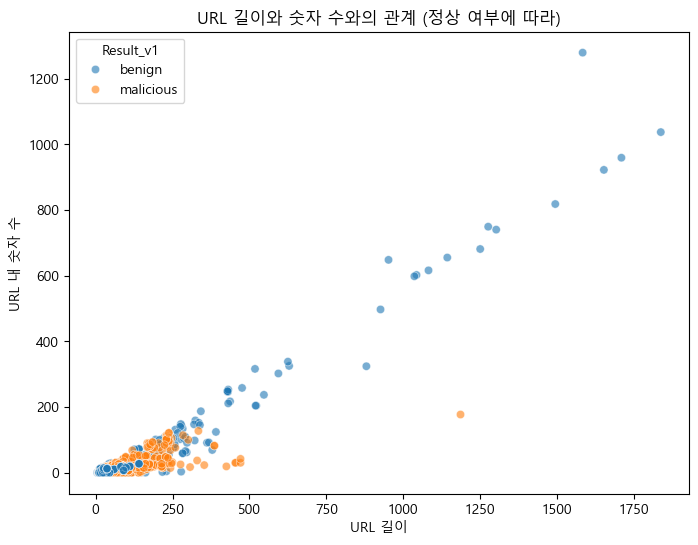

In [62]:
# url_len과 url_num_digits 관계 시각화 — 악성 URL의 특성 파악
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='url_len', y='url_num_digits', hue='Result_v1', alpha=0.6)
plt.title("URL 길이와 숫자 수와의 관계 (정상 여부에 따라)")
plt.xlabel("URL 길이")
plt.ylabel("URL 내 숫자 수")
plt.show()

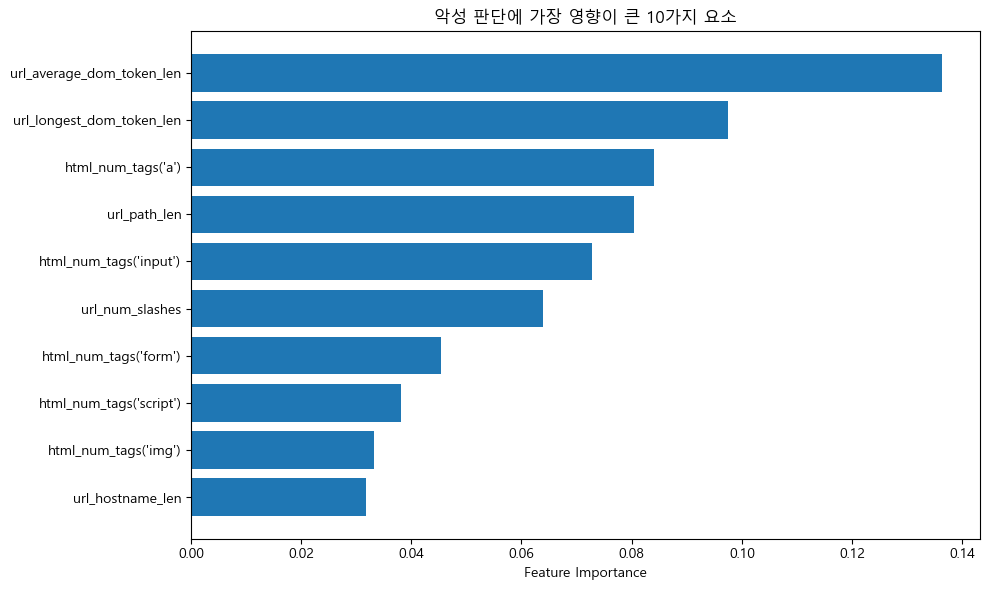

In [63]:
# 악성 판단에 가장 영향이 큰 10가지 요소
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

df_encoded = df.copy()
df_encoded['Result_v1'] = LabelEncoder().fit_transform(df_encoded['Result_v1'])

X = df_encoded.drop(columns=['Result_v1'])
y = df_encoded['Result_v1']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('악성 판단에 가장 영향이 큰 10가지 요소')
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22132\1682299105.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Result_v1', y='url_len', data=df, palette={'정상': 'skyblue', '악성': 'salmon'})
C:\Users\user\AppData\Local\Temp\ipykernel_22132\1682299105.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Result_v1', y=df["html_num_tags('script')"], data=df, palette={'정상': 'skyblue', '악성': 'salmon'})


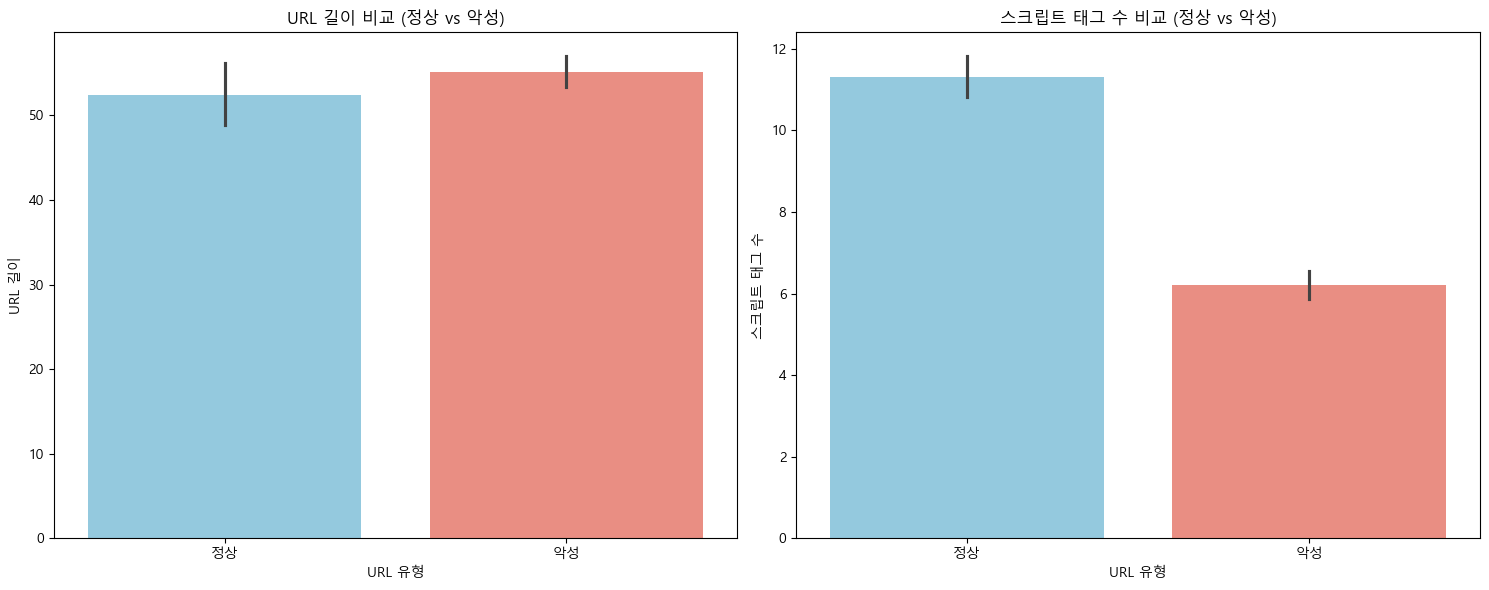

In [64]:
# 'Result_v1' 컬럼의 'benign'과 'malicious' 값을 0과 1로 매핑 (필요시)
# 이미 'benign'과 'malicious'으로 잘 되어있다면 이 부분은 건너뛰어도 됩니다.
df['Result_v1'] = df['Result_v1'].map({'benign': '정상', 'malicious': '악성'})

# 시각화 설정 (한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 사용자
# plt.rcParams['font.family'] = 'AppleGothic' # Mac 사용자
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

# 1. 막대 그래프: URL 길이 및 특정 HTML 태그 수 비교
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Result_v1', y='url_len', data=df, palette={'정상': 'skyblue', '악성': 'salmon'})
plt.title('URL 길이 비교 (정상 vs 악성)')
plt.xlabel('URL 유형')
plt.ylabel('URL 길이')

plt.subplot(1, 2, 2)
# 'html_num_tags('script')' 컬럼명에 특수문자가 있어 접근 방식 변경
sns.barplot(x='Result_v1', y=df["html_num_tags('script')"], data=df, palette={'정상': 'skyblue', '악성': 'salmon'})
plt.title('스크립트 태그 수 비교 (정상 vs 악성)')
plt.xlabel('URL 유형')
plt.ylabel('스크립트 태그 수')

plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22132\2690346860.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='URL 유형')


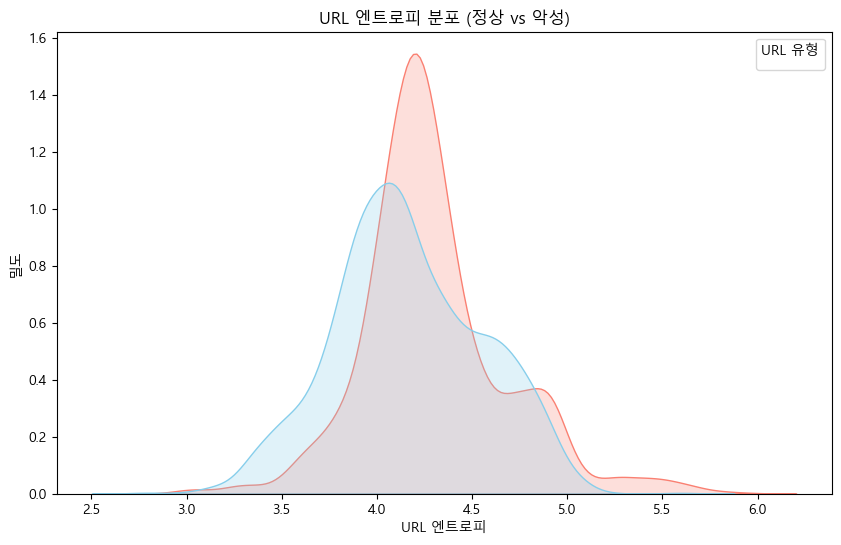

In [65]:

# 2. 히스토그램 (KDE Plot): URL 엔트로피 분포
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='url_entropy', hue='Result_v1', fill=True, common_norm=False, palette={'정상': 'skyblue', '악성': 'salmon'})
plt.title('URL 엔트로피 분포 (정상 vs 악성)')
plt.xlabel('URL 엔트로피')
plt.ylabel('밀도')
plt.legend(title='URL 유형')
plt.show()


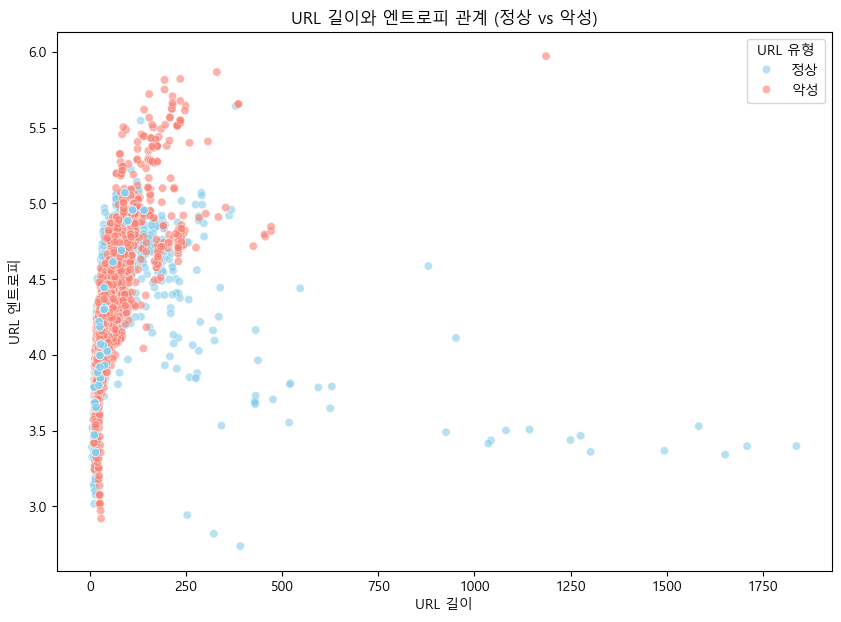

In [66]:

# 3. 산점도: URL 길이와 엔트로피 관계
plt.figure(figsize=(10, 7))
sns.scatterplot(x='url_len', y='url_entropy', hue='Result_v1', data=df, alpha=0.6, palette={'정상': 'skyblue', '악성': 'salmon'})
plt.title('URL 길이와 엔트로피 관계 (정상 vs 악성)')
plt.xlabel('URL 길이')
plt.ylabel('URL 엔트로피')
plt.legend(title='URL 유형')
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22132\1614772636.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Result_v1', y='url_num_dots', data=df, palette={'정상': 'lightgreen', '악성': 'lightcoral'})
C:\Users\user\AppData\Local\Temp\ipykernel_22132\1614772636.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Result_v1', y='url_count_consonants', data=df, palette={'정상': 'lightgreen', '악성': 'lightcoral'})


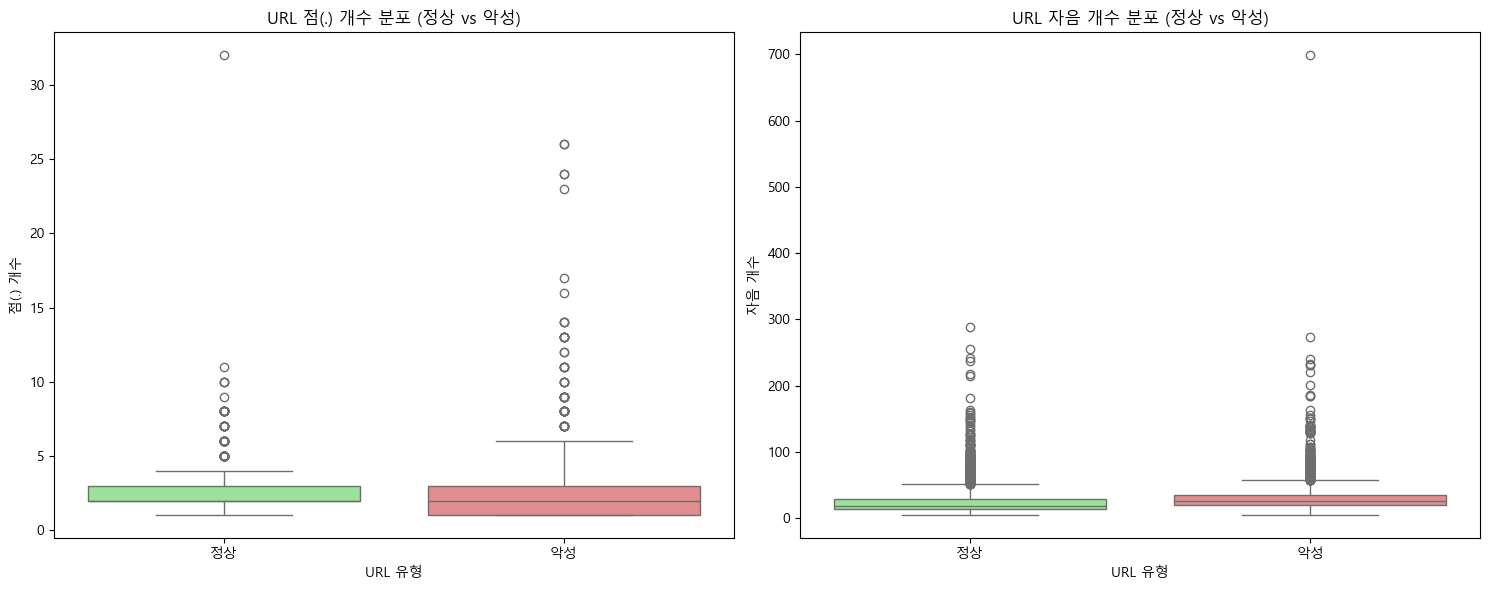

In [67]:

# 4. 박스 플롯: 주요 특징의 분포
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Result_v1', y='url_num_dots', data=df, palette={'정상': 'lightgreen', '악성': 'lightcoral'})
plt.title('URL 점(.) 개수 분포 (정상 vs 악성)')
plt.xlabel('URL 유형')
plt.ylabel('점(.) 개수')

plt.subplot(1, 2, 2)
sns.boxplot(x='Result_v1', y='url_count_consonants', data=df, palette={'정상': 'lightgreen', '악성': 'lightcoral'})
plt.title('URL 자음 개수 분포 (정상 vs 악성)')
plt.xlabel('URL 유형')
plt.ylabel('자음 개수')

plt.tight_layout()
plt.show()

#### 2. Feature Website.csv 파일을 기준으로, html 코드에 따른 악성 근거 시각화

In [68]:
# 데이터 로드
try:
    df_html = pd.read_csv('data/Feature Website.csv')
except FileNotFoundError:
    print("Feature Website.csv 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    exit()

# 컬럼명 정리: "html_code"와 "repu"만 사용
df_html = df_html[['html_code', 'repu']]

# repu 컬럼의 실제 유니크 값을 바탕으로 매핑
# ['malicious', 'benign'] -> ['악성', '정상']으로 매핑
df_html['repu'] = df_html['repu'].map({'benign': '정상', 'malicious': '악성'})

# HTML 파싱 및 특징 추출 함수 (BeautifulSoup 대신 정규표현식 사용)
# 웹에서 악성 URL을 증명하기 위한 시각화 자료이므로,
# 실제 악성 웹사이트에서 자주 보이는 특징들을 중심으로 추출합니다.
def extract_html_features_regex(html_code):
    features = {}

    # 1. HTML 태그 개수 (정규표현식으로 근사치 계산)
    # <script, <iframe, <form, <input, <a , <div 태그의 시작 부분을 찾습니다.
    # 대소문자 구분 없이 (re.IGNORECASE)
    features['num_script_tags'] = len(re.findall(r'<script', html_code, re.IGNORECASE))
    features['num_iframe_tags'] = len(re.findall(r'<iframe', html_code, re.IGNORECASE))
    features['num_form_tags'] = len(re.findall(r'<form', html_code, re.IGNORECASE))
    features['num_input_tags'] = len(re.findall(r'<input', html_code, re.IGNORECASE))
    features['num_a_tags'] = len(re.findall(r'<a\s', html_code, re.IGNORECASE)) # <a 뒤에 공백이 있는 경우
    features['num_div_tags'] = len(re.findall(r'<div', html_code, re.IGNORECASE))
    features['num_meta_tags'] = len(re.findall(r'<meta', html_code, re.IGNORECASE)) # 메타 태그 수도 유용할 수 있음
    features['num_link_tags'] = len(re.findall(r'<link', html_code, re.IGNORECASE)) # 외부 스타일시트/리소스 링크

    # 2. 특정 키워드 출현 여부/빈도
    # 악성/난독화/리다이렉션 관련 키워드
    features['keyword_eval'] = len(re.findall(r'\beval\(', html_code, re.IGNORECASE))
    features['keyword_unescape'] = len(re.findall(r'\bunescape\(', html_code, re.IGNORECASE))
    features['keyword_base64'] = len(re.findall(r'base64', html_code, re.IGNORECASE))
    features['keyword_redirect_js'] = len(re.findall(r'window\.location\.replace|window\.location\.assign|window\.location\.href|location\.replace|location\.assign|location\.href', html_code, re.IGNORECASE)) # JS 리다이렉션
    features['keyword_http_equiv_refresh'] = len(re.findall(r'<meta\s+http-equiv=["\']refresh["\']', html_code, re.IGNORECASE)) # 메타 리프레시 리다이렉션
    features['keyword_document_write'] = len(re.findall(r'document\.write', html_code, re.IGNORECASE)) # 난독화된 스크립트에서 사용
    features['keyword_phishing_terms'] = len(re.findall(r'login|password|username|account|verify|secure|update|bank|paypal|credit', html_code, re.IGNORECASE)) # 피싱 관련 일반 용어

    # 3. HTML 코드 복잡성/특징 지표
    features['html_code_len'] = len(html_code) # 전체 HTML 코드 길이
    features['num_comments'] = len(re.findall(r'', html_code, re.DOTALL)) # HTML 주석 개수 (난독화에 사용될 수 있음)
    features['num_onclick'] = len(re.findall(r'onclick=', html_code, re.IGNORECASE)) # 인라인 JS 이벤트 핸들러
    features['num_scripts_external'] = len(re.findall(r'<script\s+src=["\']http', html_code, re.IGNORECASE)) # 외부 스크립트 로드

    return features

print("HTML 특징 추출 중...")
# 각 HTML 코드에 대해 특징 추출 적용
feature_list = []
for index, row in df_html.iterrows():
    # html_code가 NaN인 경우를 대비하여 문자열로 변환
    html_content = str(row['html_code']) if pd.isna(row['html_code']) else row['html_code']
    try:
        feature_list.append(extract_html_features_regex(html_content))
    except Exception as e:
        # print(f"Error processing HTML at row {index}: {e}") # 디버깅용으로 필요시 주석 해제
        # 오류 발생 시 모든 키에 0을 할당하여 데이터 구조 유지
        # 이전에 정의된 모든 특징 키를 가져와서 0으로 초기화
        dummy_features = extract_html_features_regex("<html></html>")
        feature_list.append({key: 0 for key in dummy_features.keys()})

df_features = pd.DataFrame(feature_list)
df_html_merged = pd.concat([df_html, df_features], axis=1)
print("HTML 특징 추출 완료.")

# 시각화 설정 (한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 사용자
# plt.rcParams['font.family'] = 'AppleGothic' # Mac 사용자
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

# 'repu' 컬럼 값이 '정상'과 '악성'으로 매핑되었으므로, 이에 맞는 팔레트 설정
viz_palette = {'정상': 'skyblue', '악성': 'salmon'}


HTML 특징 추출 중...
HTML 특징 추출 완료.


C:\Users\user\AppData\Local\Temp\ipykernel_22132\1771922538.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='repu', y='num_script_tags', data=df_html_merged, palette=viz_palette)
C:\Users\user\AppData\Local\Temp\ipykernel_22132\1771922538.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='repu', y='num_form_tags', data=df_html_merged, palette=viz_palette)


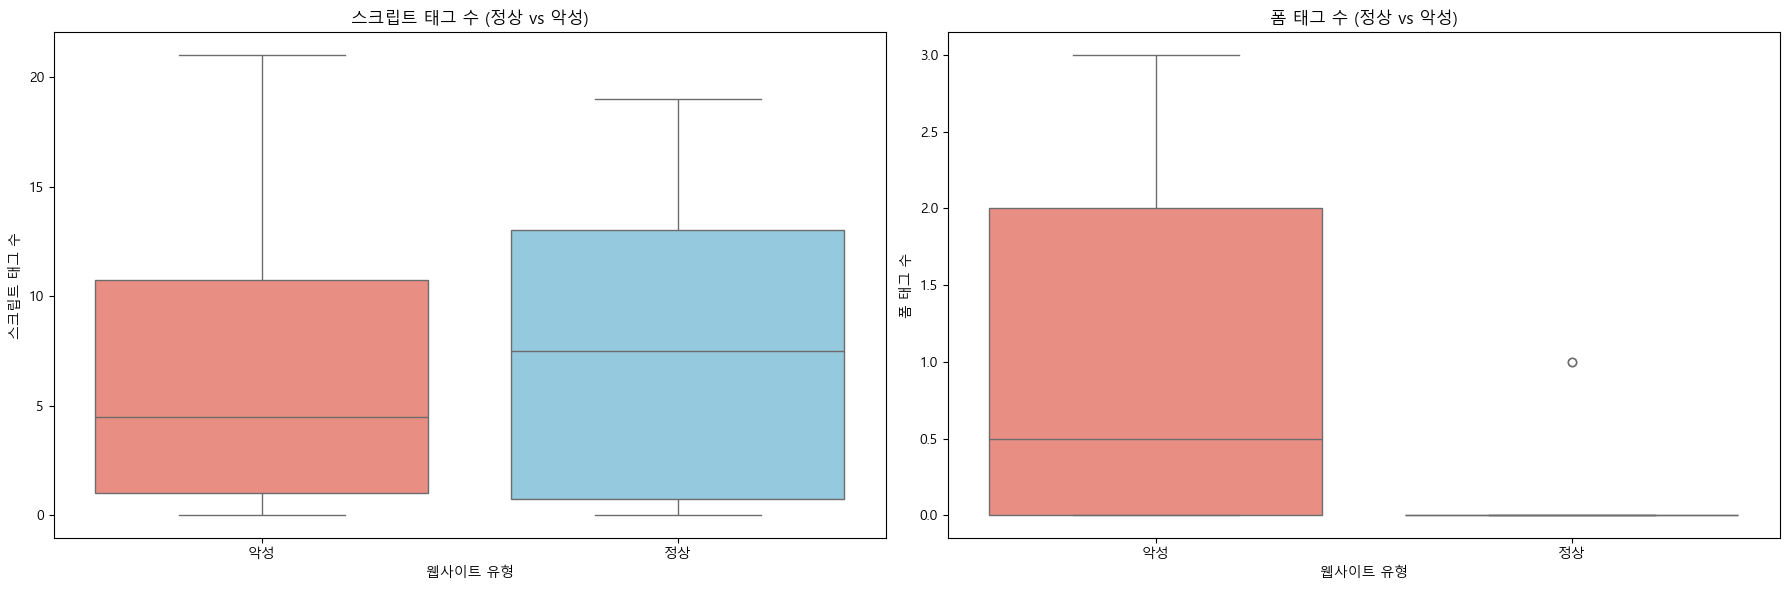

In [69]:
# 1. 주요 HTML 태그 빈도 비교 (박스 플롯)
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='repu', y='num_script_tags', data=df_html_merged, palette=viz_palette)
plt.title('스크립트 태그 수 (정상 vs 악성)')
plt.xlabel('웹사이트 유형')
plt.ylabel('스크립트 태그 수')

plt.subplot(1, 2, 2)
sns.boxplot(x='repu', y='num_form_tags', data=df_html_merged, palette=viz_palette)
plt.title('폼 태그 수 (정상 vs 악성)')
plt.xlabel('웹사이트 유형')
plt.ylabel('폼 태그 수')

plt.tight_layout()
plt.show()


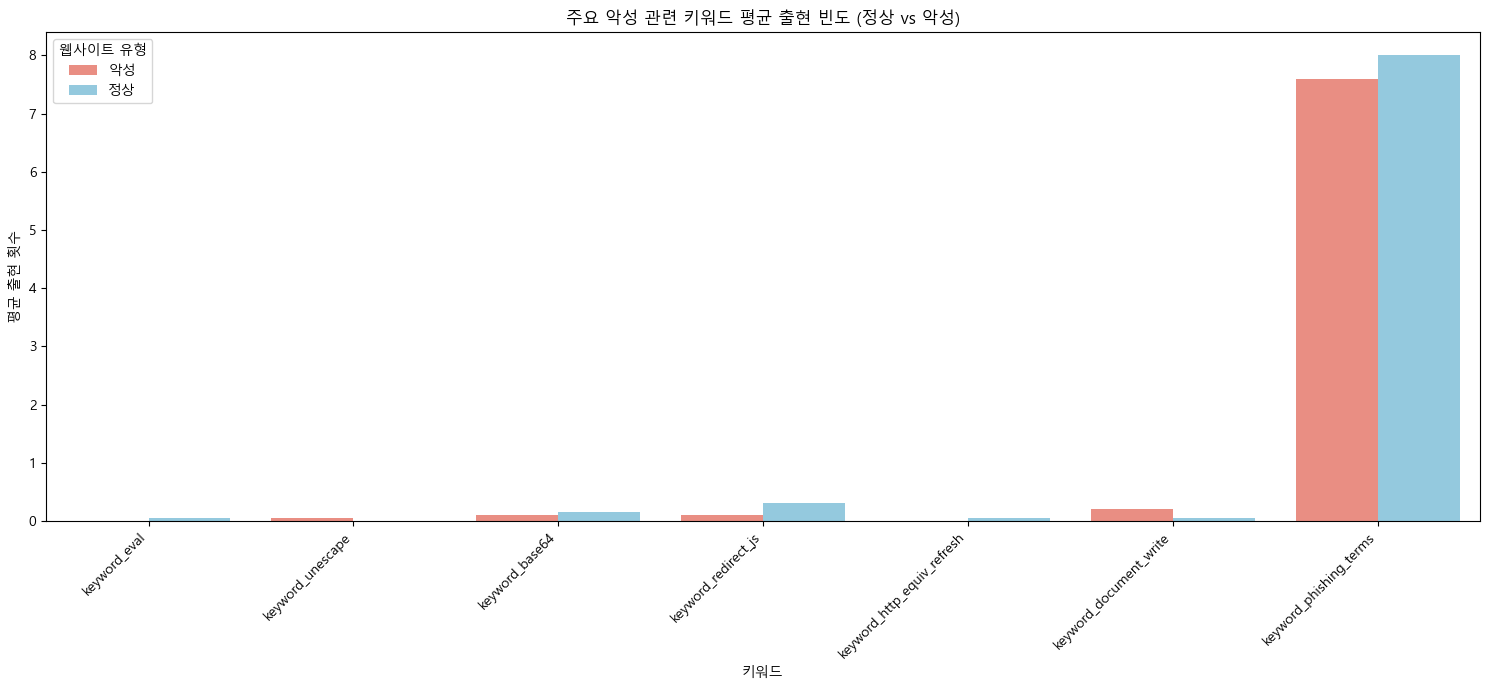

In [70]:
# 2. 특정 악성 관련 키워드 평균 출현 빈도 (막대 그래프)
plt.figure(figsize=(15, 7))

# 분석할 키워드 특징들을 정의 (추가된 키워드 포함)
keyword_features_to_plot = [
    'keyword_eval', 'keyword_unescape', 'keyword_base64',
    'keyword_redirect_js', 'keyword_http_equiv_refresh',
    'keyword_document_write', 'keyword_phishing_terms'
]

df_keyword_avg = df_html_merged.groupby('repu')[keyword_features_to_plot].mean().reset_index()
df_keyword_avg_melted = df_keyword_avg.melt(id_vars='repu', var_name='Keyword', value_name='Average Count')

sns.barplot(x='Keyword', y='Average Count', hue='repu', data=df_keyword_avg_melted, palette=viz_palette)

plt.title('주요 악성 관련 키워드 평균 출현 빈도 (정상 vs 악성)')
plt.xlabel('키워드')
plt.ylabel('평균 출현 횟수')
plt.xticks(rotation=45, ha='right')
plt.legend(title='웹사이트 유형')
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22132\2648506328.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='repu', y='num_comments', data=df_html_merged, palette=viz_palette)


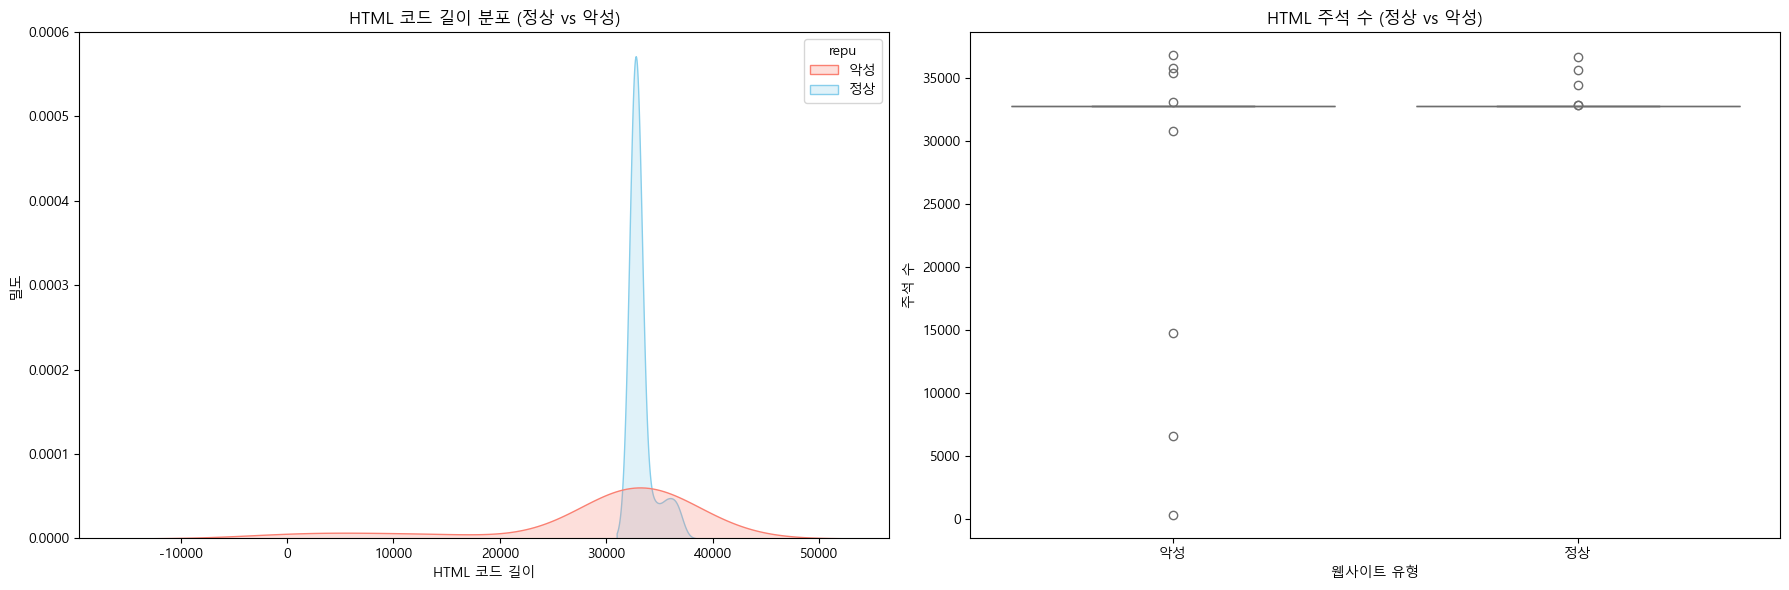

In [71]:
# 3. HTML 코드 길이 및 댓글/이벤트 핸들러 수 분포 (KDE/박스 플롯)
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(data=df_html_merged, x='html_code_len', hue='repu', fill=True, common_norm=False, palette=viz_palette)
plt.title('HTML 코드 길이 분포 (정상 vs 악성)')
plt.xlabel('HTML 코드 길이')
plt.ylabel('밀도')

plt.subplot(1, 2, 2)
sns.boxplot(x='repu', y='num_comments', data=df_html_merged, palette=viz_palette)
plt.title('HTML 주석 수 (정상 vs 악성)')
plt.xlabel('웹사이트 유형')
plt.ylabel('주석 수')

plt.tight_layout()
plt.show()



TF-IDF 변환 중...
TF-IDF 변환 중...
TF-IDF 변환 완료.
PCA 차원 축소 중...
PCA 차원 축소 완료.


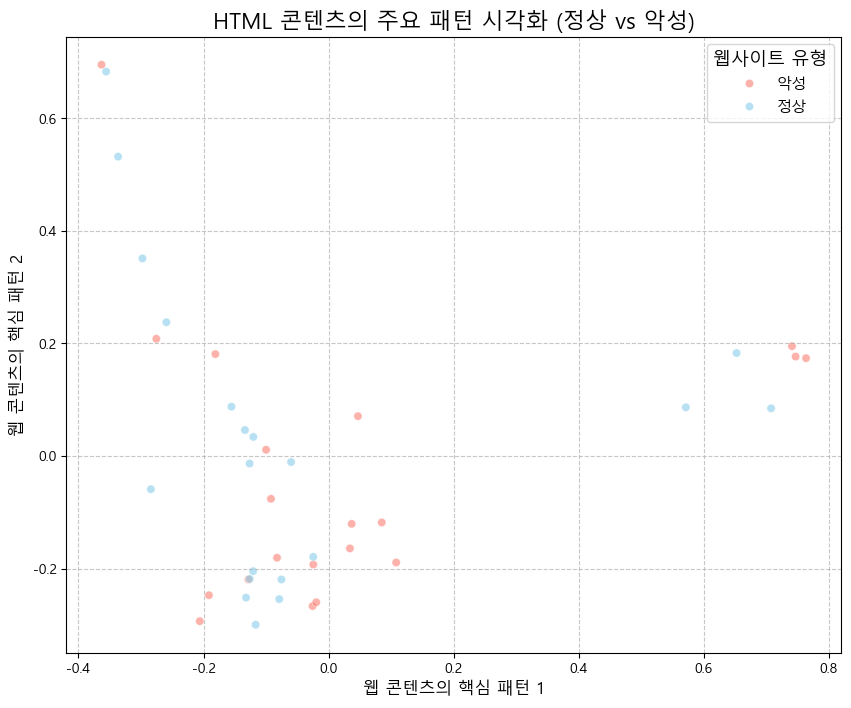

In [72]:
# 4. 웹 페이지 콘텐츠 유사성 (PCA 시각화)
# 텍스트 데이터에 TF-IDF 적용
print("TF-IDF 변환 중...")
# 결측값 및 NaN 값 처리: NaN이 아닌 문자열만 필터링
# .astype(str)로 문자열이 아닌 데이터도 문자열로 변환하여 처리

# --- PCA 시각화 부분 수정 ---
print("TF-IDF 변환 중...")
valid_html_codes = df_html_merged['html_code'].astype(str).dropna()
repu_for_valid_codes = df_html_merged.loc[valid_html_codes.index, 'repu']

if not valid_html_codes.empty:
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(valid_html_codes)
    print("TF-IDF 변환 완료.")

    print("PCA 차원 축소 중...")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(tfidf_matrix.toarray())
    df_pca = pd.DataFrame(pca_result, columns=['Component1', 'Component2']) # 컬럼명 변경
    df_pca['repu'] = repu_for_valid_codes.reset_index(drop=True)

    print("PCA 차원 축소 완료.")

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Component1', y='Component2', hue='repu', data=df_pca, alpha=0.6, palette=viz_palette)
    # 제목과 축 레이블 변경
    plt.title('HTML 콘텐츠의 주요 패턴 시각화 (정상 vs 악성)', fontsize=16)
    plt.xlabel('웹 콘텐츠의 핵심 패턴 1', fontsize=12)
    plt.ylabel('웹 콘텐츠의 핵심 패턴 2', fontsize=12)
    plt.legend(title='웹사이트 유형', title_fontsize='13', fontsize='11')
    plt.grid(True, linestyle='--', alpha=0.7) # 그리드 추가
    plt.show()
else:
    print("유효한 HTML 코드가 없어 PCA 시각화를 수행할 수 없습니다.")